# Introduction

This notebook is for experiments of neural network implementation on networks/graphs. 

### Target
- [ ] Basic framework of LSTM in Keras
- [ ] Implement NN for task-fMRI learning
- [ ] Network/graph learning framework
- [ ] Implement NN for task-fMRI connectivity learning
- [ ] Tweak NN learning for network


# LSTM for single brain region BOLD
This part is an exercise for [LSTM in Python](https://www.datacamp.com/community/tutorials/lstm-python-stock-market). First let's include required packages and data. 

In [2]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


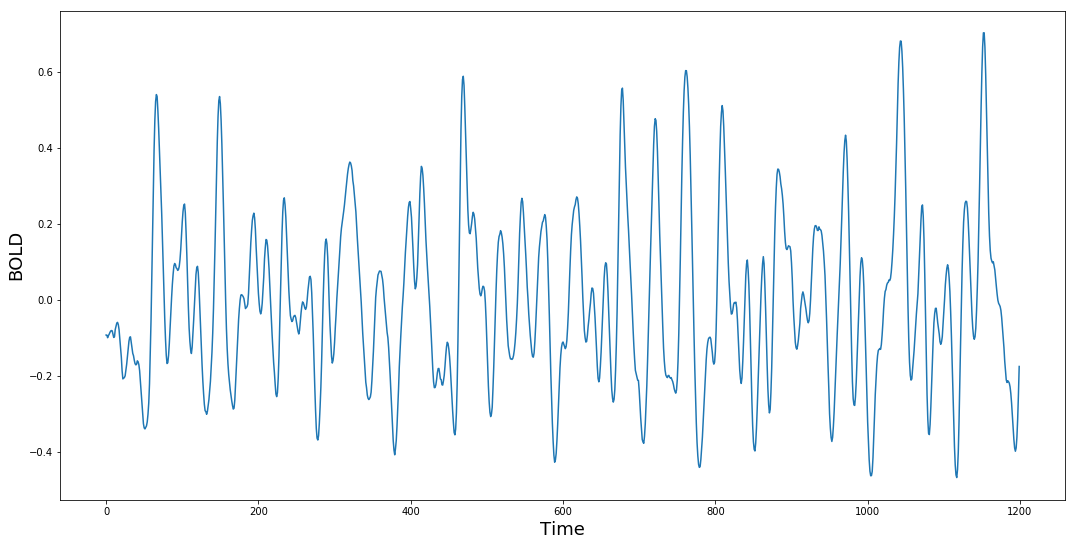

In [3]:
# Then We load the data
file_loc = '/data/results_SIFT2/148335/fMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_glasser_GS_bp_z_tseries.csv'
df = pd.read_csv(file_loc, delimiter=',',header=None).transpose()

# Visualize the time series
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df[0])
plt.xlabel('Time',fontsize=18)
plt.ylabel('BOLD',fontsize=18)
plt.show()

The figure above shows the **BOLD** signal of one region over time in resting-state. Next we'll use this time series for training/prediction. The whole time series has length of 1200 then the first $3/4$ data points are used for training and the rest will be the test data. LSTM can predict time series with certain window size. For instance, if we have the time series of time $[0, T]$, then we can predict the data of $[\Delta t, T+\Delta t]$. Here, $\Delta t$ is the argument `look_back`

In [10]:
# Function for creating dataset with \Delta t
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = df[0].values.reshape(-1,1)
dataset = scaler.fit_transform(dataset)

# Split the data into training and test
train_data = dataset[:round(.75*df.shape[0])]
test_data = dataset[round(.75*df.shape[0]):]

# Reproduce the data one step later
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



## fitting the time series w/ LSTM
Here we're gonna use LSTM to fit this scaled stock price data. Won't talk too much about LSTM here because [this article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) gives a **very good** explanation of this model. 

Some moving average can make very accurate prediction on next time step value. However, what we really want is an approximate trend for next few time points such as "if the stock price will go up or down for the next week". In this example, we use a chunk of 500 time points as input size and predict the next 50 steps data. 

Next we transform the data into input/output batches for training:

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 1s - loss: 0.0310


In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

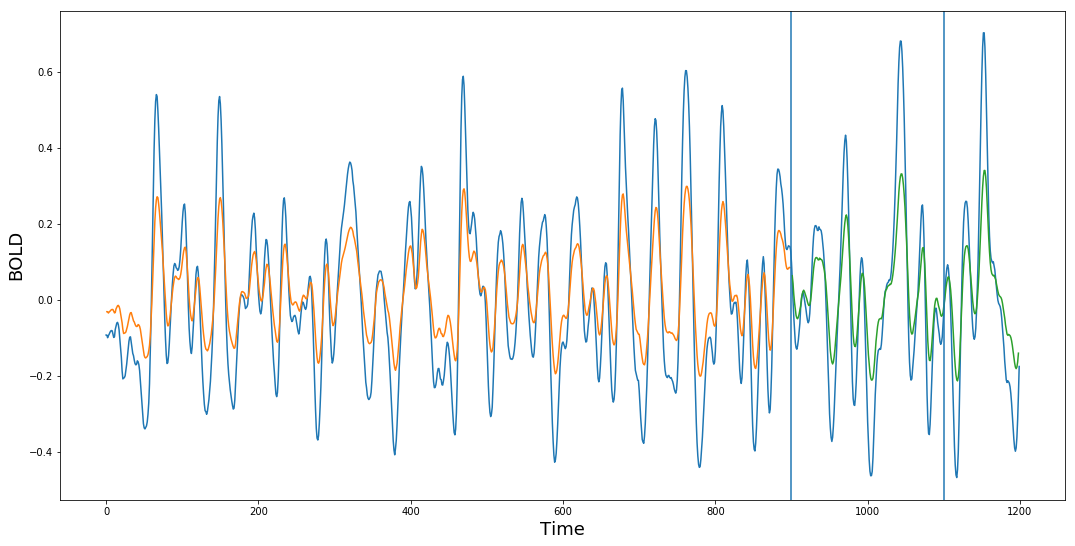

In [13]:
# plot baseline and predictions
plt.figure(figsize = (18,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.axvline(x=900)
plt.axvline(x=1100)
plt.xlabel('Time',fontsize=18)
plt.ylabel('BOLD',fontsize=18)
plt.show()

## Task recognition for fMRI data using LSTM
In this section, we are gonna use LSTM to train the time series data with label of tasks. First we have observed multivariate data, time course of 360 regions(variables). The predicted variable is the task they are taking. We pick 30 subjects and pick a random chunk of video to be trained on. 

But before everything, the images need to be converted to .jpg to get trained. Let's do this.

In [ ]:
import scipy.misc
import os
import pandas as pd

for subj in os.listdir("/data/results_SIFT2"):
    os.chdir("/data/results_SIFT2/"+subj+"/fMRI")
    for sess in os.listdir():
        if sess[0] != 'r':
            file_loc = sess+'/'+sess+'_glasser_GS_z_tseries.csv'
            df = pd.read_csv(file_loc, delimiter=',',header=None).transpose()
            scipy.misc.imsave('outfile.jpg', df)